In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [19]:
import torch
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10


# MNIST
def mnist(batch_sz):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                    ])
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, shuffle=True,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader, num_classes


# CIFAR10
def cifar10(batch_sz):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(32, padding=4),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                    ])
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    # Training dataset
    train_data = CIFAR10(root='./datasets', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz,
                                               shuffle=True, pin_memory=True)

    # Test dataset
    test_data = CIFAR10(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader, num_classes

In [20]:
train_loader,test_loader,_=mnist(5)

In [21]:
#Q1: define a 2 layer simple NN for mnist digit classificaiton
class FC(nn.Module):
    def __init__(self):
        super(FC,self).__init__()
        self.fcn=nn.Sequential(
            nn.Linear(784,64),
            nn.ReLU(inplace=True),
            nn.Linear(64,10),
            nn.ReLU(inplace=True),

        )

    def forward(self,x):
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x=self.fcn(x)
        return x


In [22]:
#Q2: Define a CNN with 2 conv layer and 2 linear layers for mnist digit communication
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(1,4,3)
        self.conv2=nn.Conv2d(4,6,3)
        self.l1=nn.Linear(3456,64)
        self.l2=nn.Linear(64,10)

    def forward(self,x):
        x=torch.relu(self.conv1(x))
        x=torch.relu(self.conv2(x))
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x=torch.relu(self.l1(x))
        x=torch.relu(self.l2(x))
        return x


In [23]:
def get_accuracy(model,test_loader,device):
    size=len(test_loader.dataset)
    model.eval()
    correct=0
    with torch.no_grad():
        for X,y in test_loader:
            X,y=X.to(device),y.to(device)
            pred_y=model(X)
            correct+=(pred_y.argmax(1)==y).type(torch.float).sum().item()
    accuracy=correct/size
    return accuracy

def train(model,train_loader,test_loader,optimizer,loss_fn,device,epochs,model_name):
    total_time=0.0
    for epoch in range(epochs):
        print(f"Epoch {epoch}-------------------------------")
        model.train()
        size=len(train_loader.dataset)
        start_time=time.time()
        for batch_idx,(X,y) in enumerate(train_loader):
            X,y=X.to(device),y.to(device)

            pred_y=model(X)
            loss=loss_fn(pred_y,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch_idx%4000==0:
                loss,current=loss.item(),batch_idx*len(X)
                print(f"loss:{loss:>7f}[{current:>5d}/{size:>5d}]")

        delta_time=time.time()-start_time
        total_time+=delta_time
        accuracy=get_accuracy(model,test_loader,device)
        print("Accuracy in test set: %.3f}"%accuracy)

        torch.save(model.state_dict(),'checkpoints/'+model_name+f'/epoch-{epoch}.pth')
    print('Time cost for training',epochs,'epochs in',device,':',total_time,'s.')
    

In [24]:
#Q3: Train both networks for 10 epochs and compare their performance 
#Q4: Compare the accuarcay of both networks on the test set
device='cpu'
fc=FC().to(device)

optimizer = torch.optim.SGD(fc.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
train(fc,train_loader,test_loader,optimizer,loss_fn,device,10,'fc')

Epoch 0-------------------------------
loss:2.327881[    0/60000]
loss:1.439797[20000/60000]
loss:0.952322[40000/60000]
Accuracy in test set: 0.774}
Epoch 1-------------------------------
loss:0.498963[    0/60000]
loss:0.550277[20000/60000]
loss:0.721883[40000/60000]
Accuracy in test set: 0.851}
Epoch 2-------------------------------
loss:0.238156[    0/60000]
loss:0.325734[20000/60000]
loss:0.583151[40000/60000]
Accuracy in test set: 0.867}
Epoch 3-------------------------------
loss:0.085052[    0/60000]
loss:0.574877[20000/60000]
loss:0.661814[40000/60000]
Accuracy in test set: 0.866}
Epoch 4-------------------------------
loss:0.140524[    0/60000]
loss:0.209369[20000/60000]
loss:0.364140[40000/60000]
Accuracy in test set: 0.872}
Epoch 5-------------------------------
loss:0.291146[    0/60000]
loss:0.746031[20000/60000]
loss:0.166712[40000/60000]
Accuracy in test set: 0.881}
Epoch 6-------------------------------
loss:0.188488[    0/60000]
loss:0.089806[20000/60000]
loss:0.272135

In [45]:
device='cpu'
cnn=CNN().to(device)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
train(cnn,train_loader,test_loader,optimizer,loss_fn,device,10,'cnn')

Epoch 0-------------------------------
loss:2.302367[    0/60000]
loss:1.660445[20000/60000]
loss:0.875073[40000/60000]
Accuracy in test set: 0.855}
Epoch 1-------------------------------
loss:1.134869[    0/60000]
loss:0.262140[20000/60000]
loss:0.460882[40000/60000]
Accuracy in test set: 0.904}
Epoch 2-------------------------------
loss:0.719502[    0/60000]
loss:0.072001[20000/60000]
loss:1.050036[40000/60000]
Accuracy in test set: 0.912}
Epoch 3-------------------------------
loss:0.646304[    0/60000]
loss:0.273374[20000/60000]
loss:0.006309[40000/60000]
Accuracy in test set: 0.932}
Epoch 4-------------------------------
loss:0.056672[    0/60000]
loss:0.363513[20000/60000]
loss:0.041708[40000/60000]
Accuracy in test set: 0.929}
Epoch 5-------------------------------
loss:0.798023[    0/60000]
loss:0.007359[20000/60000]
loss:0.028474[40000/60000]
Accuracy in test set: 0.942}
Epoch 6-------------------------------
loss:0.847158[    0/60000]
loss:0.028330[20000/60000]
loss:0.274380

pred: 2 ; gt: 5
pred: 3 ; gt: 5
pred: 8 ; gt: 3


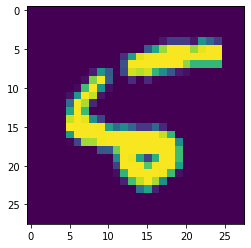

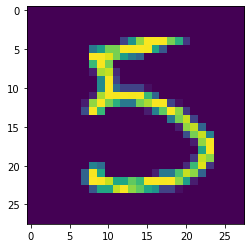

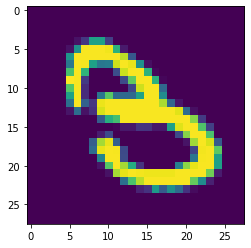

In [25]:
#Q5: go through the testset and plot some samples of incorrect results
device='cpu'
fc=FC().to(device)
cnn=CNN().to(device)

fc.load_state_dict(torch.load('checkpoints/fc/epoch-9.pth'))
cnn.load_state_dict(torch.load('checkpoints/cnn/epoch-9.pth'))

fc.eval()
cnn.eval()

cnt=0
for batch_idx,(X,y) in enumerate(test_loader):
    if cnt>2:
        break

    fc_y=fc(X)
    cnn_y=cnn(X)
    pred_fc=fc_y.argmax(1)
    pred_cnn=cnn_y.argmax(1)
    for j in range(5):
        if pred_fc[j]!=y[j]:
            cnt+=1
            plt.figure()
            plt.imshow(X[j,0,:,:])
            print('pred:',int(pred_fc[j]),'; gt:',int(y[j]))
            break
    for j in range(5):
        if pred_cnn[j]!=y[j]:
            cnt+=1
            plt.figure()
            plt.imshow(X[j,0,:,:])
            print('pred:',int(pred_cnn[j]),'; gt:',int(y[j]))
            break

In [33]:
#Q6: show the output of the intermediate layers
for batch_idx,(X,y) in enumerate(train_loader):
    for i in range(len(fc.fcn)):
        X = X.view(-1, int(X.nelement() / X.shape[0]))
        X=fc.fcn[i](X)
        print(X)
    break

tensor([[-2.7193e+00, -2.1193e+00, -3.4796e+00, -3.8691e+00,  1.7287e+00,
          7.6587e-01, -4.4357e+00,  9.9788e-01,  4.7680e+00,  1.0446e-01,
          1.0237e-01, -2.1224e+00, -5.5369e-01,  1.2651e+00, -1.8526e-01,
          3.6613e+00,  1.7720e-01,  1.2649e+00, -2.8835e-01, -3.5003e-01,
          1.4118e+00, -4.0313e-02,  2.0936e+00,  2.5204e+00, -3.1782e+00,
         -3.2846e-01, -2.2891e+00,  1.1355e+00,  2.5412e-01, -2.8621e-01,
         -1.3694e+00,  4.9118e-01,  4.4491e+00, -1.2165e+00,  7.0441e-01,
          4.0541e+00, -1.8305e+00,  1.4239e-01, -9.5959e-01, -1.2643e-03,
          6.3949e-01, -6.8372e-01,  2.5166e-01, -5.9142e-01,  1.1985e+00,
         -2.1808e-02, -1.1314e+00,  1.4964e+00, -1.9381e+00, -7.5101e-01,
         -9.3552e-01, -1.8608e+00, -2.7040e-01,  1.2296e+00, -6.9750e-01,
         -2.1582e+00,  1.4223e+00,  2.5236e-01, -1.8599e-01, -1.4541e+00,
          1.8466e-01,  2.5537e-01, -3.8305e+00,  3.9588e-01],
        [ 2.9955e+00,  2.0391e+00, -7.5994e+00, -2

In [34]:
#Q7: Compare the time of training on CPU and GPU
device='cuda'
cnn=CNN().to(device)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
train(cnn,train_loader,test_loader,optimizer,loss_fn,device,10,'cnn')

AssertionError: Torch not compiled with CUDA enabled

torch.Size([5, 1, 28, 28])
gt: 6
gt: 7
gt: 9
gt: 1
gt: 3


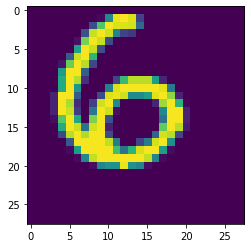

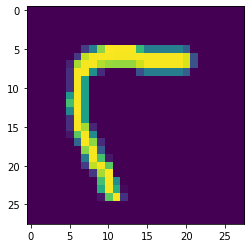

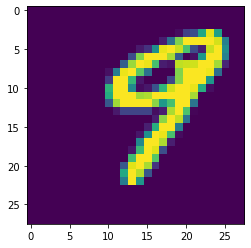

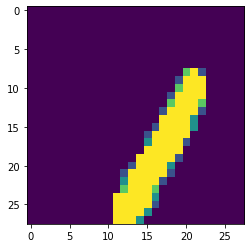

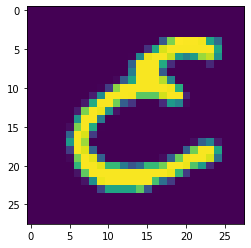

In [55]:
for i,batch in enumerate(train_loader):
    if i>0:
        break

    x=batch[0]
    y=batch[1]
    
    print(x.shape)
    for j in range(5):
        plt.figure()
        plt.imshow(x[j,0,:,:])
        print('gt:',int(y[j]))  
        